<a href="https://colab.research.google.com/github/AmritaNeogi/AI_term_project.io/blob/main/ql_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Cartpole Deep Q-Learning**

**Importing all required packages and libraries**

In [1]:
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1



In [2]:
%%bash
pip3 install gymnasium[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 38.1 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0


In [3]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [4]:
# Install packages
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

import gym
import copy
import torch
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
import math
import torchvision.transforms as T
import numpy as np
import time
import math
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay


**Setting up the Environment**

In [5]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

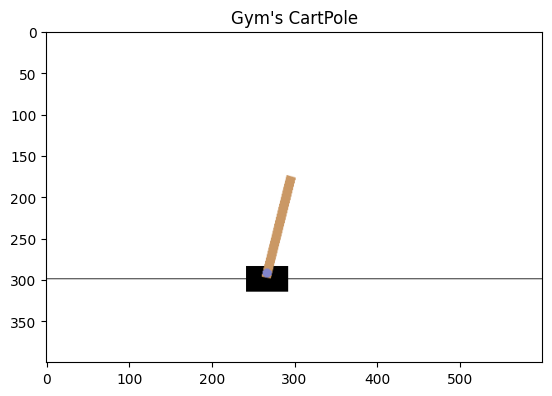

In [ ]:
env = gym.make("CartPole-v0") # Cart-Pole game environment
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)
plt.title("Gym's CartPole")

for i in range(50):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close() # to shut the window showing the simulation

In [ ]:
rewards = []
for _ in range(100):
    env.render(mode='rgb_array')
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

We can execute to see the rewards

In [ ]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


**Plotting Function**

This will help us analyse the result

In [ ]:
def plot_func(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, pl = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    pl[0].plot(values, color='blue', label='score per run')
    pl[0].axhline(195, c='red',ls='--', label='goal')
    pl[0].set_xlabel('Episodes')
    pl[0].set_ylabel('Reward')
    x = range(len(values))
    pl[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        pl[0].plot(x,p(x),"--", color='orange', label='trend')
    except:
        print('')
    
    # histogram of results
    pl[1].hist(values[-50:], color='green')
    pl[1].axvline(195, c='red', label='goal')
    pl[1].set_xlabel('Scores per Last 50 Episodes')
    pl[1].set_ylabel('Frequency')
    pl[1].legend()
    plt.show()


**Random Search**

In [ ]:
def random_search(env, episodes, title='Baseline Model'):
    """
    Implementation of the random search strategy.
    
    Arguments:
    - env: gym environment
    - episodes: number of episodes to run
    - title: title for the plot
    
    Returns:
    - final: list of rewards obtained in each episode
    """
    final = []  # Initialize a list to store the final rewards
    for episode in range(episodes):
        state = env.reset()  # Reset the environment to start a new episode
        done = False
        total = 0  # Initialize the total reward for the episode to zero
        while not done:
            action = env.action_space.sample()  # Sample a random action from the action space
            next_state, reward, done, _ = env.step(action)  # Take the action and observe the results
            total += reward  # Update the total reward for the episode
            if done:
                break
        final.append(total)  # Add the total reward for the episode to the final rewards list
        plot_func(final, title)  # Plot the reward curve and histogram of results so far
    return final  # Return the list of final rewards obtained in each episode


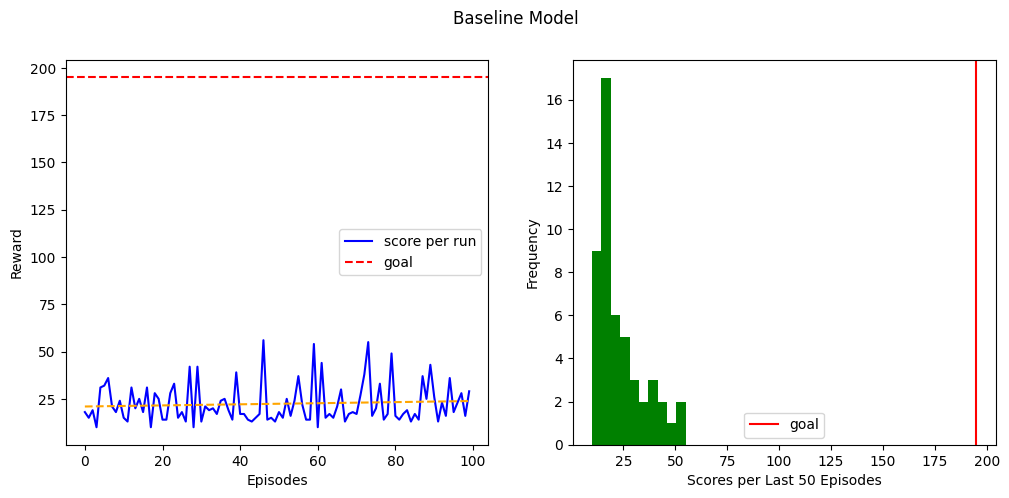

In [ ]:
# Get random search results
random_s = random_search(env, 100)

So, here we can see the avaerage is as low as 10 steps.

**Deep Q Learning**

𝑄 : **𝑆𝑡𝑎𝑡𝑒 × 𝐴𝑐𝑡𝑖𝑜𝑛 → ℝ**

In [ ]:
class DQL():
    """
    The DQL class implementation consists of a simple neural network implemented
    in PyTorch that has two main methods — predict and update.
    """
    def __init__(self, state_dim, action_dim, hidden_dim=64, lr=0.05):
        """
        Initializes the DQL model.
        
        Arguments:
        - state_dim: dimension of the state space
        - action_dim: dimension of the action space
        - hidden_dim: number of hidden units in the neural network
        - lr: learning rate for the optimizer
        """
        self.criterion = torch.nn.MSELoss()  # Mean squared error loss function
        self.model = torch.nn.Sequential(
            torch.nn.Linear(state_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim*2),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim*2, action_dim)
        )  # Define the neural network architecture
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)  # Adam optimizer with given learning rate
    
    def update(self, state, y):
        """
        Updates the weights of the network on the given training data.
        
        Arguments:
        - state: input state for training
        - y: target output for training
        """
        y_pred = self.model(torch.Tensor(state))  # Forward pass to get the predicted output
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))  # Compute the loss between predicted and target output
        self.optimizer.zero_grad()  # Zero out gradients to avoid accumulation
        loss.backward()  # Compute gradients by backpropagation
        self.optimizer.step()  # Update the weights of the network based on the gradients computed
        
    def predict(self, state):
        """
        Computes the Q values for all actions using the DQL.
        
        Arguments:
        - state: input state for computing Q values
        
        Returns:
        - Q values for all actions for the given state
        """
        with torch.no_grad():  # Avoids computing gradients during prediction
            return self.model(torch.Tensor(state))  # Forward pass to get the Q values for all actions for the given state


**Q-Learning Algorithm**

In [ ]:
def q_learning(env, model, episodes, gamma=0.9, epsilon=0.3, eps_decay=0.99,
               replay=False, replay_size=20, title='DQL', double=False,
               n_update=10, soft=False, verbose=True):
    """Implementation of the Deep Q Learning algorithm using the DQN.

    Args:
        env: A gym environment.
        model: An instance of the DQL class that represents the Q-network.
        episodes: The number of episodes to run the algorithm for.
        gamma: The discount factor.
        epsilon: The probability of choosing a random action instead of the 
                 greedy action.
        eps_decay: The rate at which epsilon decays over time.
        replay: Whether or not to use experience replay.
        replay_size: The size of the replay memory buffer.
        title: The title of the plot of the final rewards.
        double: Whether or not to use Double Q-learning.
        n_update: The number of episodes between each target network update.
        soft: Whether or not to use soft target network updates.
        verbose: Whether or not to print out episode information.

    Returns:
        A list of the total rewards obtained for each episode.
    """

    final = []
    memory = []
    episode_i = 0
    sum_total_replay_time = 0
    
    for episode in range(episodes):
        episode_i += 1
        
        if double and not soft:
            # Update target network every n_update steps
            if episode % n_update == 0:
                model.target_update()
                
        if double and soft:
            model.target_update()
            
        # Reset state
        state = env.reset()
        done = False
        total = 0
        
        while not done:
            # Implement greedy search policy to explore the state space
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_values = model.predict(state)
                action = torch.argmax(q_values).item()
            
            # Take action and add reward to total
            next_state, reward, done, _ = env.step(action)
            
            # Update total and memory
            total += reward
            memory.append((state, action, next_state, reward, done))
            q_values = model.predict(state).tolist()
             
            if done:
                if not replay:
                    q_values[action] = reward
                    # Update network weights
                    model.update(state, q_values)
                break

            if replay:
                t0 = time.time()
                # Update network weights using replay memory
                model.replay(memory, replay_size, gamma)
                t1 = time.time()
                sum_total_replay_time += (t1 - t0)
            else:
                # Update network weights using the last step only
                q_values_next = model.predict(next_state)
                q_values[action] = reward + gamma * torch.max(q_values_next).item()
                model.update(state, q_values)

            state = next_state
        
        # Update epsilon
        epsilon = max(epsilon * eps_decay, 0.01)
        final.append(total)
        plot_func(final, title)
        
        if verbose:
            print("episode: {}, total reward: {}".format(episode_i, total))
            if replay:
                print("Average replay time:", sum_total_replay_time / episode_i)
        
    return final



**Parameters**

In [ ]:
# Number of states
n_state = env.observation_space.shape[0]
# Number of actions
n_action = env.action_space.n
# Number of episodes
episodes = 150
# Number of hidden nodes in the DQN
n_hidden = 50
# Learning rate
lr = 0.001

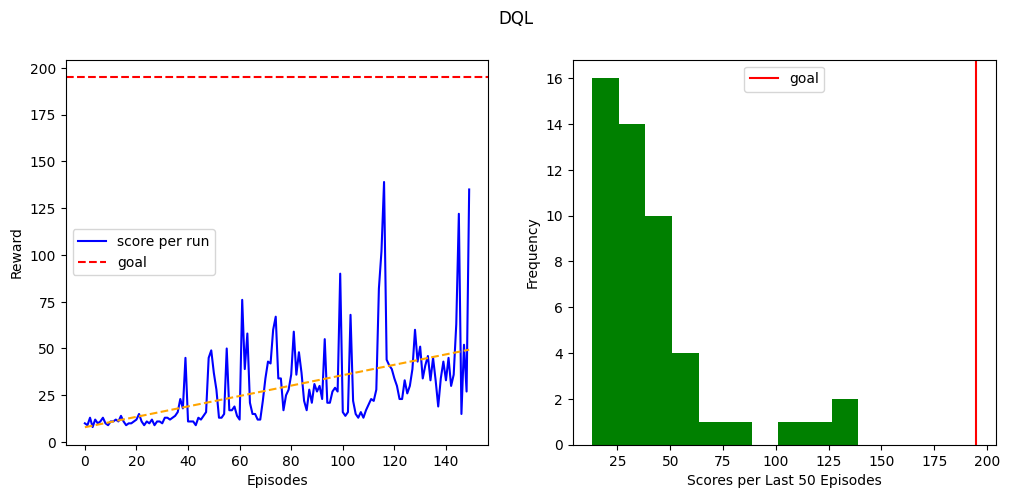

episode: 150, total reward: 135.0


In [ ]:
# DQL results
dqn = DQL(n_state, n_action, n_hidden, lr)
q = q_learning(env, dqn, episodes, gamma=.9, epsilon=0.3)

**Replay** **Memory**

In [ ]:
# Expand DQL class with a replay function.
class Replay(DQL):
       # OLD REPLAY FUNCTION
      """Add experience replay to the DQL network class."""
      # def replay(self, memory, size, gamma=0.9):
       
      #   # Check if memory has enough samples to start replaying
      #   if len(memory) >= size:
                 
      #   # Create empty lists to store states and targets
      #     states = []
      #     targets = []
        
      #     # Randomly sample a batch of experiences from memory
      #     batch = random.sample(memory, size)
        
      #     # Extract information from the data and update targets
      #     for state, action, next_state, reward, done in batch:
      #         states.append(state)
            
      #         # Predict Q-values for the current state
      #         q_values = self.predict(state).tolist()
            
      #         if done:
      #           # If episode ended, set Q-value of the action to the reward
      #           q_values[action] = reward
      #         else:
      #           # If episode didn't end, update Q-value based on Bellman equation
      #           q_values_next = self.predict(next_state)
      #           q_values[action] = reward + gamma * torch.max(q_values_next).item()
     
      #         targets.append(q_values)

      #     # Update the agent's model with the updated Q-values
      #     self.update(states, targets)

      #new replay function
      def replay(self, memory, size, gamma=0.9):
        """Replay function for reinforcement learning"""
        # Check if there are enough memories in memory to replay
        if len(memory) >= size:
            
            # Select a random batch of memories from memory
            batch = random.sample(memory, size)
            
            # Transpose the batch list to get lists of states, actions, next states, rewards, and is_dones
            batch_t = list(map(list, zip(*batch)))
            states = batch_t[0]
            actions = batch_t[1]
            next_states = batch_t[2]
            rewards = batch_t[3]
            is_dones = batch_t[4]
            
            # Convert states, actions, next_states, rewards, and is_dones to tensors
            states = torch.Tensor(states)
            actions_tensor = torch.Tensor(actions)
            next_states = torch.Tensor(next_states)
            rewards = torch.Tensor(rewards)
            is_dones_tensor = torch.Tensor(is_dones)
            
            # Get the indices of the memories where is_dones is True
            is_dones_indices = torch.where(is_dones_tensor==True)[0]
            
            # Get the predicted q_values of all states and next states
            all_q_values = self.model(states) 
            all_q_values_next = self.model(next_states)
            
            # Update q_values
            all_q_values[range(len(all_q_values)),actions]=rewards+gamma*torch.max(all_q_values_next, axis=1).values
            all_q_values[is_dones_indices.tolist(), actions_tensor[is_dones].tolist()]=rewards[is_dones_indices.tolist()]
        
            # Update the model with the new states and q_values
            self.update(states.tolist(), all_q_values.tolist())


**Old Replay Function**

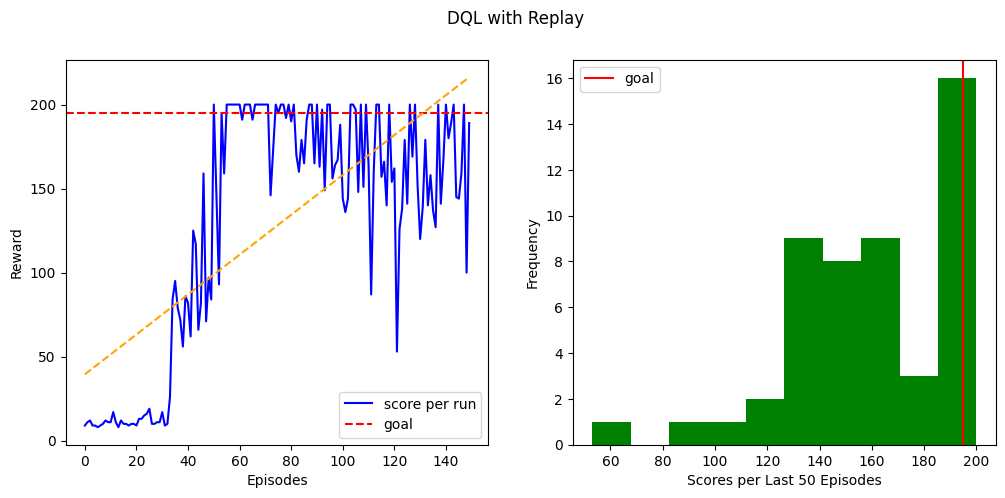

episode: 150, total reward: 189.0
Average replay time: 0.8158576075236003


In [ ]:
# replay results
dqn_replay = Replay(n_state, n_action, n_hidden, lr)
replay = q_learning(env, dqn_replay, 
                    episodes, gamma=.9, 
                    epsilon=0.2, replay=True, 
                    title='DQL with Replay')

**New Replay Function**

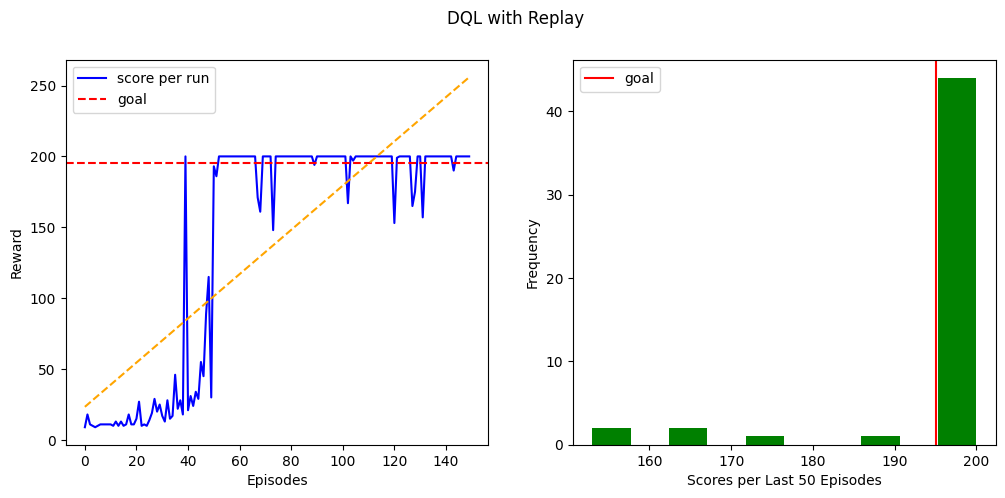

episode: 150, total reward: 200.0
Average replay time: 0.33570114612579344


In [ ]:
# replay results
dqn_replay = Replay(n_state, n_action, n_hidden, lr)
replay = q_learning(env, dqn_replay, 
                    episodes, gamma=.9, 
                    epsilon=0.2, replay=True, 
                    title='DQL with Replay')

As anticipated, the neural network that incorporates replay appears to be considerably stronger and intelligent in comparison to the one that only retains the most recent action.

**Creating Agent**

The base code is inspired from: 
https://github.com/IsaacPatole/CartPole-v0-using-Q-learning-SARSA-and-DNN/blob/master/Qlearning_for_cartpole.py

In [ ]:
class CartPoleQAgent():
    def __init__(self, buckets=(3, 3, 6, 6), 
                 num_episodes=500, min_lr=0.1, 
                 min_epsilon=0.1, discount=1.0, decay=25):
        self.buckets = buckets
        self.num_episodes = num_episodes
        self.min_lr = min_lr
        self.min_epsilon = min_epsilon
        self.discount = discount
        self.decay = decay

        self.env = gym.make('CartPole-v0')
        
        # This is the action-value function being initialized to 0's
        self.Q_table = np.zeros(self.buckets + (self.env.action_space.n,))

        # [position, velocity, angle, angular velocity]
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]
        
        self.steps = np.zeros(self.num_episodes)
        self.num_successes = 0
    def discretize_state(self, obs):
        """
        Takes an observation of the environment and aliases it.
        By doing this, very similar observations can be treated
        as the same and it reduces the state space so that the 
        Q-table can be smaller and more easily filled.
        
        Input:
        obs (tuple): Tuple containing 4 floats describing the current
                     state of the environment.
        
        Output:
        discretized (tuple): Tuple containing 4 non-negative integers smaller 
                             than n where n is the number in the same position
                             in the buckets list.
        """
        discretized = list()
        for i in range(len(obs)):
            scaling = ((obs[i] + abs(self.lower_bounds[i])) 
                       / (self.upper_bounds[i] - self.lower_bounds[i]))
            new_obs = int(round((self.buckets[i] - 1) * scaling))
            new_obs = min(self.buckets[i] - 1, max(0, new_obs))
            discretized.append(new_obs)
        return tuple(discretized)   
    def choose_action(self, state):
        """
        Implementation of e-greedy algorithm. Returns an action (0 or 1).
        
        Input:
        state (tuple): Tuple containing 4 non-negative integers within
                       the range of the buckets.
        
        Output:
        (int) Returns either 0 or 1
        """
        if (np.random.random() < self.epsilon):
            return self.env.action_space.sample() 
        else:
            return np.argmax(self.Q_table[state])
    def get_action(self, state, e):
        """
        Another policy based on the Q-table. Slight variation from 
        e-greedy. It assumes the state fed hasn't been discretized and 
        returns a vector with probabilities for each action.
        
        Input: 
        state (tuple): Contains the 4 floats used to describe
                       the current state of the environment.
        e (int): Denotes the episode at which the agent is supposed
                 to be, helping balance exploration and exploitation.
                 
        Output:
        action_vector (numpy array): Vector containing the probability
                                     of each action being chosen at the
                                     current state.
        """
        obs = self.discretize_state(state)
        action_vector = self.Q_table[obs]
        epsilon = self.get_epsilon(e)
        action_vector = self.normalize(action_vector, epsilon)
        return action_vector 
    def normalize(self, action_vector, epsilon):
        """
        Returns a vector with components adding to 1. Ensures 
        
        Input:
        action_vector (numpy array): Contains expected values for each
                                     action at current state from Q-table.
        epsilon (float): Chances that the e-greedy algorithm would 
                         choose an action at random. With this pol
        
        Output:
        new_vector (numpy array): Vector containing the probability
                                  of each action being chosen at the
                                  current state.
        """
        
        total = sum(action_vector)
        new_vector = (1-epsilon)*action_vector/(total)
        new_vector += epsilon/2.0
        return new_vector      
    def update_q(self, state, action, reward, new_state):
        """
        Updates Q-table using the rule as described by Sutton and Barto in
        Reinforcement Learning.
        """
        self.Q_table[state][action] += (self.learning_rate * 
                                        (reward 
                                         + self.discount * np.max(self.Q_table[new_state]) 
                                         - self.Q_table[state][action]))

    def get_epsilon(self, t):
        """Gets value for epsilon. It declines as we advance in episodes."""
        # Ensures that there's almost at least a min_epsilon chance of randomly exploring
        return max(self.min_epsilon, min(1., 1. - math.log10((t + 1) / self.decay)))

    def get_learning_rate(self, t):
        """Gets value for learning rate. It declines as we advance in episodes."""
        # Learning rate also declines as we add more episodes
        return max(self.min_lr, min(1., 1. - math.log10((t + 1) / self.decay)))

    def train(self):
        """
        Trains agent making it go through the environment and choose actions
        through an e-greedy policy and updating values for its Q-table. The 
        agent is trained by default for 500 episodes with a declining 
        learning rate and epsilon values that with the default values,
        reach the minimum after 198 episodes.
        """
        # Looping for each episode
        for e in range(self.num_episodes):
            # Initializes the state
            current_state = self.discretize_state(self.env.reset())

            self.learning_rate = self.get_learning_rate(e)
            self.epsilon = self.get_epsilon(e)
            done = False
            
            # Looping for each step
            while not done:
                self.steps[e] += 1
                # Choose A from S
                action = self.choose_action(current_state)
                # Take action
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(obs)
                # Update Q(S,A)
                self.update_q(current_state, action, reward, new_state)
                current_state = new_state
                # We break out of the loop when done is False which is
                # a terminal state.
        print('Finished training!')
    
    def run(self):
        for i in range(self.num_episodes):
            # Reset environment for new episode
            state = self.discretize_state(self.env.reset())
            self.learning_rate = self.get_learning_rate(i)
            self.epsilon = self.get_epsilon(i)
            done = False
            step = 0
            
            while not done:
                action = self.choose_action(state)
                # Execute action in environment
                new_state, reward, done, _ = self.env.step(action)
                new_state = self.discretize_state(new_state)
                self.update_q(state, action, reward, new_state)
                state = new_state
                step += 1
                
            self.steps[i] = step
            if step == 200:
                self.num_successes += 1
            
            if i % 100 == 0:                
                plt.plot(self.steps[:i+1], color='blue')
                plt.title("Steps per Episode")
                plt.xlabel("Episode")
                plt.ylabel("Steps")
                plt.show()
                
        print(f"Number of successful episodes: {self.num_successes}")

In [ ]:
def load_q_learning():
  agent = CartPoleQAgent() 
  agent.train()
  agent.run()
  return agent

Finished training!


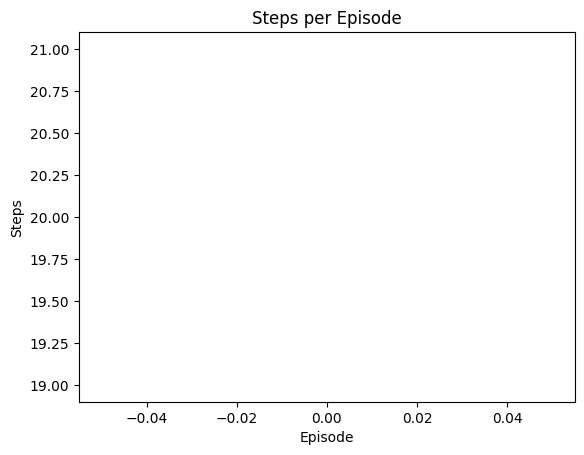

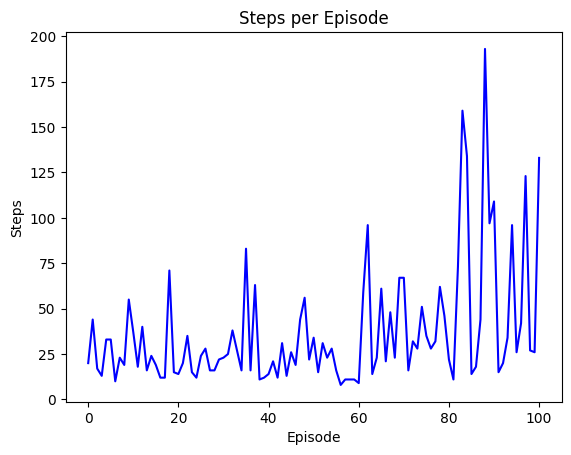

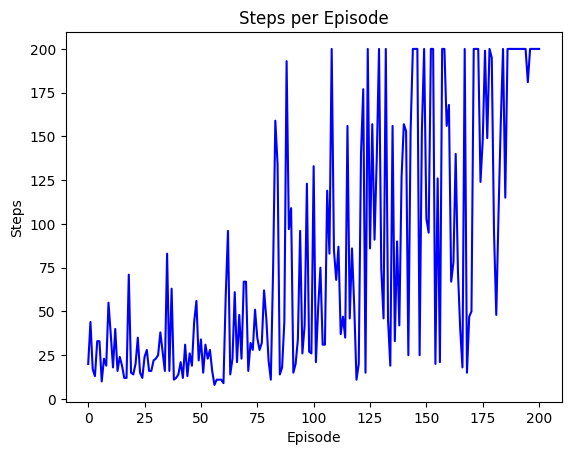

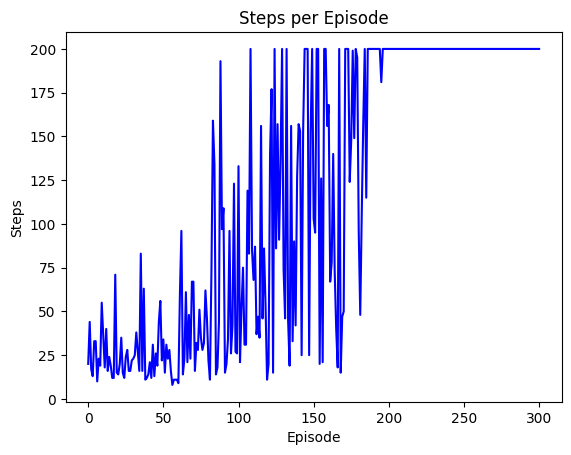

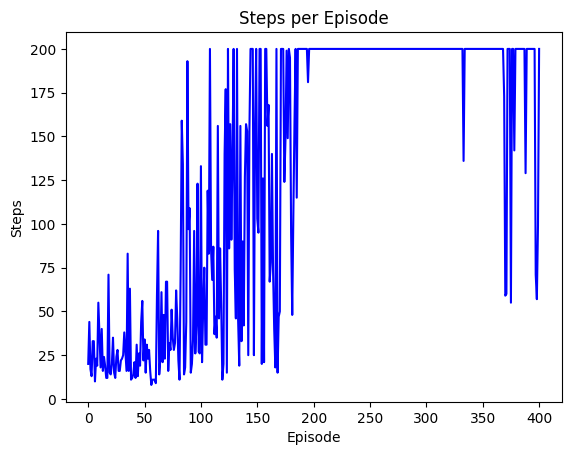

Number of successful episodes: 314


In [ ]:
agent = load_q_learning()

